# SHAP values from scratch
> How SHAP values are computed, in a few simple Python lines

- comments: true
- badges: true
- categories: [ai]
- publishes: true

SHAP values are great for understanding a model. The basic logic of how they work is quite simple and worth trying to reproduce with raw Python.

On a high level, the logic is the following: To get the importance of a feature, let's remove then add it back, on every sample. By checking the impact of removing/adding the feature on the prediction for that sample, we have the importance of the feature for that sample. We can then aggregate to get the feature importance overall. This is why we loop over all samples and all features in each sample below.

The only thing to add is that if we just use the existing samples, we only compute the impact of removing/adding the feature when all other features of the sample are present. The point of SHAP is to perform the operation with every combination of other features removed. This is why below we compute the coalitions.

In [181]:
import pandas as pd
from sklearn.datasets import load_breast_cancer
from sklearn.linear_model import LogisticRegression
from sympy.utilities.iterables import multiset_permutations
from tqdm.notebook import tqdm
from pprint import pprint
import numpy as np


# 1. Loading a dataset and fitting a model

In [102]:
X, y = load_breast_cancer(return_X_y=True, as_frame=True)

In [ ]:
lr = LogisticRegression(max_iter=100, verbose=0).fit(X.values, y.values)

# 2. Computing feature importance 

## 2.1 Creating "coalitions"

Coalitions are list of 0s and 1s representing all possible combinations of features.

Ideally, we would use all possible coalitions, to cover all the possible cases. In practice, extreme coalitions (mostly 1s and mostly 0s) are used. In our case, as we use pure Python, we will only consider a few coalitions.

This image, from the great SHAP explanation [here](https://christophm.github.io/interpretable-ml-book/shap.html#kernelshap), shows the way coalitions are used to remove features and replace them by the average values (in red)

![](https://christophm.github.io/interpretable-ml-book/images/shap-simplified-features.jpg)



In [192]:
coalitions = []
for i in [0,1, len(X.columns)-1, len(X.columns)]: 
  num_ones = i 
  num_zeroes = len(X.columns) - i
  coalitions += list(multiset_permutations([0] * num_zeroes + [1] * num_ones))

pd.DataFrame(coalitions).head(10).style.applymap(lambda v: 'background-color:red' if v == 1 else None)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


## 2.2 Computing the feature impact

He is the pseudo-logic
- For every coalition
  - For every sample in the dataset, replace "0" in coalition with average feature value for that sample
    - For every feature of the sample
      - Compute model score wihtout and with the feature. The difference is the impact of that feature, on that sample, for that coalition. 


Aggregate all the impacts

In [ ]:
# We will gather all feature impacts 
feature_impacts = {col:[] for col in X.columns}

# The mean values are used for when a feature needs to be "removed"
mean_values = X.mean().values

# For each coalition we have prepared (1s and 0s)
for coalition in tqdm(pd.DataFrame(coalitions).astype(bool).values, total=len(coalitions)): 

  # For each sample in the dataset
  for sample in X.values: 

    # In the sample, replace all the '0s' of the coalition
    # with the mean of that feature
    sample_masked = sample.copy()
    sample_masked[~coalition] = mean_values[~coalition] 

    # For each feature
    for feature_idx, feature_name in enumerate(X.columns):

      # Compute the score without the feature
      sample_without_feature = sample_masked.copy()
      sample_without_feature[feature_idx] = mean_values[feature_idx]
      score_without_feature = lr.predict_proba([sample_without_feature])[0][1]

      # Compute the score with the feature
      sample_with_feature = sample_masked.copy()
      sample_with_feature[feature_idx] = sample[feature_idx]
      score_with_feature = lr.predict_proba([sample_with_feature])[0][1]

      # Store the feature impact
      feature_impacts[feature_name].append(score_with_feature - score_without_feature)

In [154]:
pd.DataFrame(feature_impacts, columns=X.columns).head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,0.722058,-0.126389,0.869852,-0.128361,-0.000087,-0.003189,-0.005405,-0.001073,-3.318434e-04,-0.000017,...,0.870383,0.780434,-0.128907,-0.128907,-0.000214,-0.022046,-0.028566,-0.003150,-0.002920,-0.000195
1,0.856055,-0.060093,0.871019,-0.128904,0.000046,0.000479,0.000049,-0.000233,-2.085911e-07,0.000007,...,0.870042,0.188555,-0.128906,-0.128907,0.000061,0.003977,0.002225,-0.001500,0.000262,-0.000028
2,0.837193,0.137117,0.870927,-0.128886,-0.000052,-0.001030,-0.002803,-0.000864,-1.407096e-04,0.000003,...,0.866727,0.008583,-0.128905,-0.128905,-0.000086,-0.009560,-0.012331,-0.002686,-0.001230,-0.000020
3,-0.117599,0.066944,-0.126242,0.790957,-0.000182,-0.003304,-0.003923,-0.000616,-4.289558e-04,-0.000038,...,-0.092544,-0.039935,0.412002,0.789438,-0.000554,-0.031548,-0.027105,-0.002987,-0.006344,-0.000496
4,0.851585,-0.113725,0.871053,-0.128902,-0.000016,-0.000529,-0.002818,-0.000606,1.432269e-06,0.000004,...,0.858891,0.804422,-0.128905,-0.128897,-0.000036,0.002886,-0.008952,-0.001008,0.000934,0.000040


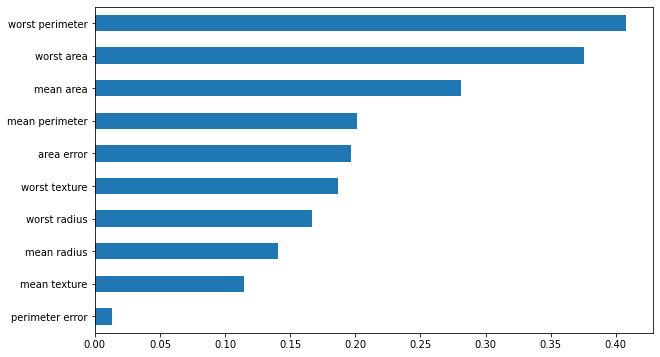

In [161]:
pd.DataFrame(feature_impacts).abs().mean().sort_values().iloc[-10:].plot.barh(figsize=(10, 6))

# Comparing to SHAP

The calculation above should get us close to the SHAP values

In [118]:
%%capture
!pip install shap

In [119]:
import shap

In [ ]:
expl = shap.KernelExplainer(lambda x: lr.predict_proba(x)[:, 1], X.mean())
shap_values = expl.shap_values(X)

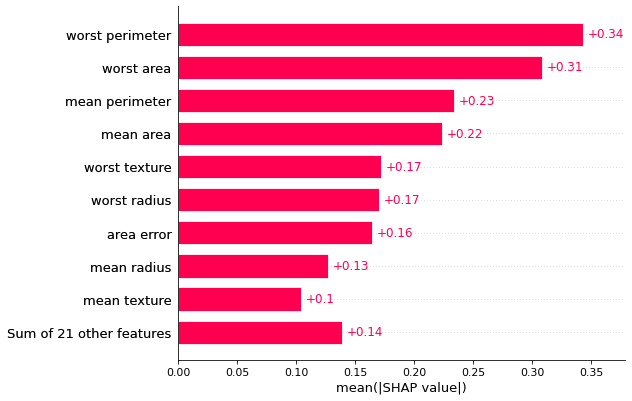

In [190]:
shap.plots.bar(shap.Explanation(shap_values, np.repeat(expl.expected_value, len(shap_values)), feature_names=X.columns))

It is highlighting the same set of top features as our manual method, with similar feature importance values.

We would get better results if we considered more coalitions, but the problem becomes exponentially harder.